In [1]:
#!python3 -m pip install cityscapesscripts

In [2]:
#!python -m pip install cityscapesscripts[gui]
# need it?

In [ ]:
from PIL import Image
from cityscapesscripts.helpers import labels
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

In [4]:
# Set seeds for reproducibility
def set_seeds(seed=42):
    """Set seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
SEED = 42
set_seeds(SEED)
print(f"Seeds set for reproducibility is {SEED}")

Seeds set for reproducibility is 42


In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() 
                      else "mps" if torch.mps.is_available() 
                      else "cpu"
                    )
print(DEVICE)

mps


Actual Colors:


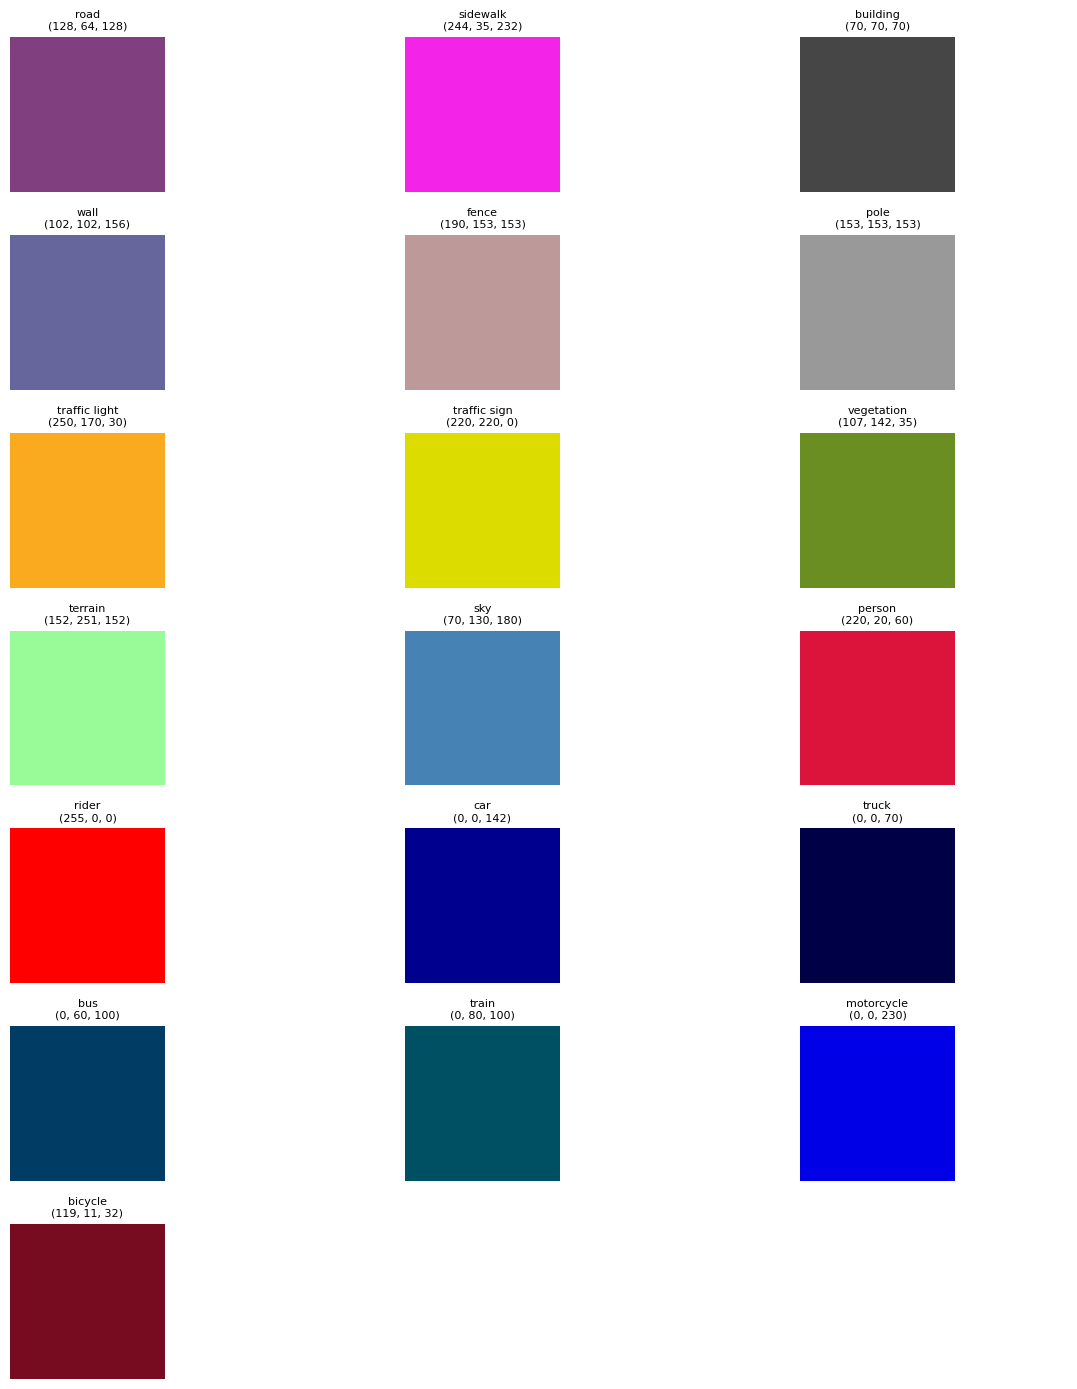

In [6]:
print("Actual Colors:")

# Calculate grid dimensions (3 colors per row)
cols = 3

labels = [label for label in labels.labels if label.trainId != 255 and label.trainId != -1]
rows = (len(labels) + cols - 1) // cols  # Ceiling division

# Create a figure and axes to display the colors in a grid
fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 2))

# Flatten axes array for easier indexing
if rows == 1:
    axes = [axes] if cols == 1 else axes
else:
    axes = axes.flatten()

for i, label in enumerate(labels): 
    color = np.array(label.color) / 255.0  # Normalize RGB values to [0, 1]
    axes[i].imshow([[color]])  # Display the color as a small image
    # Add color name and RGB values to the title
    axes[i].set_title(f"{label.name}\n{label.color}", fontsize=8)
    axes[i].axis('off')  # Hide the axes

# Hide any unused subplots
for i in range(len(labels), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [7]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, targets_dir, image_transform=None, target_transform=None):
        """
        Args:
            images_dir (string): Directory with all the images.
            targets_dir (string): Directory with all the target masks.
            image_transform (callable, optional): Optional transform to be applied on images.
            target_transform (callable, optional): Optional transform to be applied on targets.
        """
        self.images_dir = images_dir
        self.targets_dir = targets_dir
        self.image_transform = image_transform
        self.target_transform = target_transform
        
        # Get all image filenames
        self.image_filenames = [f for f in os.listdir(images_dir) 
                               if f.lower().endswith(('.png'))]
        self.image_filenames.sort()
        
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        # Load image
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        # Load target mask
        target_name = img_name.replace('.png', '_trainId.png')
        target_path = os.path.join(self.targets_dir, target_name)
        target = Image.open(target_path)
        
        # Apply transforms
        if self.image_transform:
            image = self.image_transform(image)
        
        if self.target_transform:
            target = self.target_transform(target)
       # else:
       #     # Default: convert to tensor
       #     target = torch.from_numpy(target)
        
        return image, target

In [8]:
path_images = "syn_resized_images"
path_target = "syn_resized_gt"

image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),  # Converts PIL Image to Tensor
])

target_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.Lambda(lambda x: torch.from_numpy(np.array(x)).long())
])
syn_dataset = SegmentationDataset(images_dir=path_images, targets_dir=path_target, image_transform=image_transform, target_transform=target_transform)


In [26]:
# Get total dataset size
total_size = len(syn_dataset)
print(f"Total dataset size: {total_size}")

# Calculate split sizes (60% train, 10% val, 30% test)
train_size = int(0.6 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

print(f"Train size: {train_size} ({train_size/total_size*100:.1f}%)")
print(f"Validation size: {val_size} ({val_size/total_size*100:.1f}%)")
print(f"Test size: {test_size} ({test_size/total_size*100:.1f}%)")

# Create random splits
syn_train_dataset, syn_val_dataset, syn_test_dataset = random_split(
    syn_dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(SEED)  # For reproducibility
)

# Create DataLoaders
batch_size = 6  


syn_train_dataloader = DataLoader(
    syn_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED) 
)


syn_val_dataloader = DataLoader(
    syn_val_dataset,
    batch_size=batch_size,
    shuffle=True,  
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED)
)

syn_test_dataloader = DataLoader(
    syn_test_dataset,
    batch_size=batch_size,
    shuffle=True,  
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED)
)

print(f"\nDataLoaders created:")
print(f"Train batches: {len(syn_train_dataloader)}")
print(f"Validation batches: {len(syn_val_dataloader)}")
print(f"Test batches: {len(syn_test_dataloader)}")

Total dataset size: 5000
Train size: 3000 (60.0%)
Validation size: 500 (10.0%)
Test size: 1500 (30.0%)

DataLoaders created:
Train batches: 500
Validation batches: 84
Test batches: 250


In [ ]:
import ssl
import urllib.request
from contextlib import contextmanager
# Disable SSL verification for urllib requests on MacOS
# This is a workaround for the "SSL: CERTIFICATE_VERIFY_FAILED" error on MacOS
@contextmanager
def no_ssl_verification():
    """Temporarily disable SSL verification"""
    old_context = ssl._create_default_https_context
    ssl._create_default_https_context = ssl._create_unverified_context
    try:
        yield
    finally:
        ssl._create_default_https_context = old_context
        

if DEVICE.type == 'mps': 
    print("mps detected, using no_ssl_verification")
    with no_ssl_verification():
        WEIGHTS = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
        model = deeplabv3_resnet50(weights=WEIGHTS)
else:
    WEIGHTS = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
    model = deeplabv3_resnet50(weights=WEIGHTS)

NUM_CLASSES = 19  # Cityscapes
LR = 1e-4

model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
model.to(DEVICE)

criterion = nn.CrossEntropyLoss(ignore_index=255)  # 255 = unlabeled

optimizer = optim.Adam(model.parameters(), lr=LR)


mps detected, using no_ssl_verification


In [ ]:
def compute_iou(preds, labels, num_classes, ignore_index=255):
    preds = torch.argmax(preds, dim=1)  # [B, H, W]
    ious = []
    
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (labels == cls)
        
        # Escludi pixel ignorati
        mask = (labels != ignore_index)
        pred_inds = pred_inds & mask
        target_inds = target_inds & mask

        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        
        if union == 0:
            continue  # salta classe non presente
        ious.append(intersection / union)
    
    if len(ious) == 0:
        return float('nan')  # o 0.0 se preferisci
    return sum(ious) / len(ious)

In [27]:
def train_and_validate_epoch(model, train_dataloader, val_dataloader, optimizer, criterion):
    """
    Train for one epoch and validate on validation set
    Returns: train_loss, train_iou, val_loss, val_iou
    """
    # Training phase
    model.train()
    train_total_loss = 0
    train_total_iou = 0
    
    for images, masks in tqdm(train_dataloader, desc="Training"):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_total_loss += loss.item()
        train_total_iou += compute_iou(outputs.detach(), masks, NUM_CLASSES)

    train_avg_loss = train_total_loss / len(train_dataloader)
    train_avg_iou = train_total_iou / len(train_dataloader)
    
    # Validation phase
    model.eval()
    val_total_loss = 0
    val_total_iou = 0
    
    with torch.no_grad():
        for images, masks in tqdm(val_dataloader, desc="Validating"):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            
            val_total_loss += loss.item()
            val_total_iou += compute_iou(outputs, masks, NUM_CLASSES)
    
    val_avg_loss = val_total_loss / len(val_dataloader)
    val_avg_iou = val_total_iou / len(val_dataloader)
    
    return train_avg_loss, train_avg_iou, val_avg_loss, val_avg_iou

In [ ]:
epochs = 5

# Store metrics for plotting
train_losses = []
train_ious = []
val_losses = []
val_ious = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Train and validate in one go
    train_loss, train_iou, val_loss, val_iou = train_and_validate_epoch(
        model, syn_train_dataloader, syn_val_dataloader, optimizer, criterion
    )
    
    # Store metrics
    train_losses.append(train_loss)
    train_ious.append(train_iou)
    val_losses.append(val_loss)
    val_ious.append(val_iou)
    
    # Print results
    print(f"Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f}")
    print("-" * 50)

Epoch 1/5


Validating: 100%|██████████| 84/84 [00:29<00:00,  2.80it/s]


Train Loss: 0.1593 | Train IoU: 0.5699
Val Loss: 0.2374 | Val IoU: 0.4903
--------------------------------------------------
Epoch 2/5


Validating: 100%|██████████| 84/84 [00:29<00:00,  2.80it/s]


Train Loss: 0.1517 | Train IoU: 0.5830
Val Loss: 0.2396 | Val IoU: 0.4851
--------------------------------------------------
Epoch 3/5


Validating: 100%|██████████| 84/84 [00:29<00:00,  2.85it/s]


Train Loss: 0.1470 | Train IoU: 0.5886
Val Loss: 0.2441 | Val IoU: 0.4942
--------------------------------------------------
Epoch 4/5


Training:  77%|███████▋  | 385/500 [05:58<01:47,  1.07it/s]

In [14]:
torch.save({
    "epoch": epochs,
    "model_state_dict" : model.state_dict(),
    "optimizer_state_dict" : optimizer.state_dict(),
    "loss" : train_loss,
    }, "models/deeplabv3.pth")

Visualizing segmentation results...


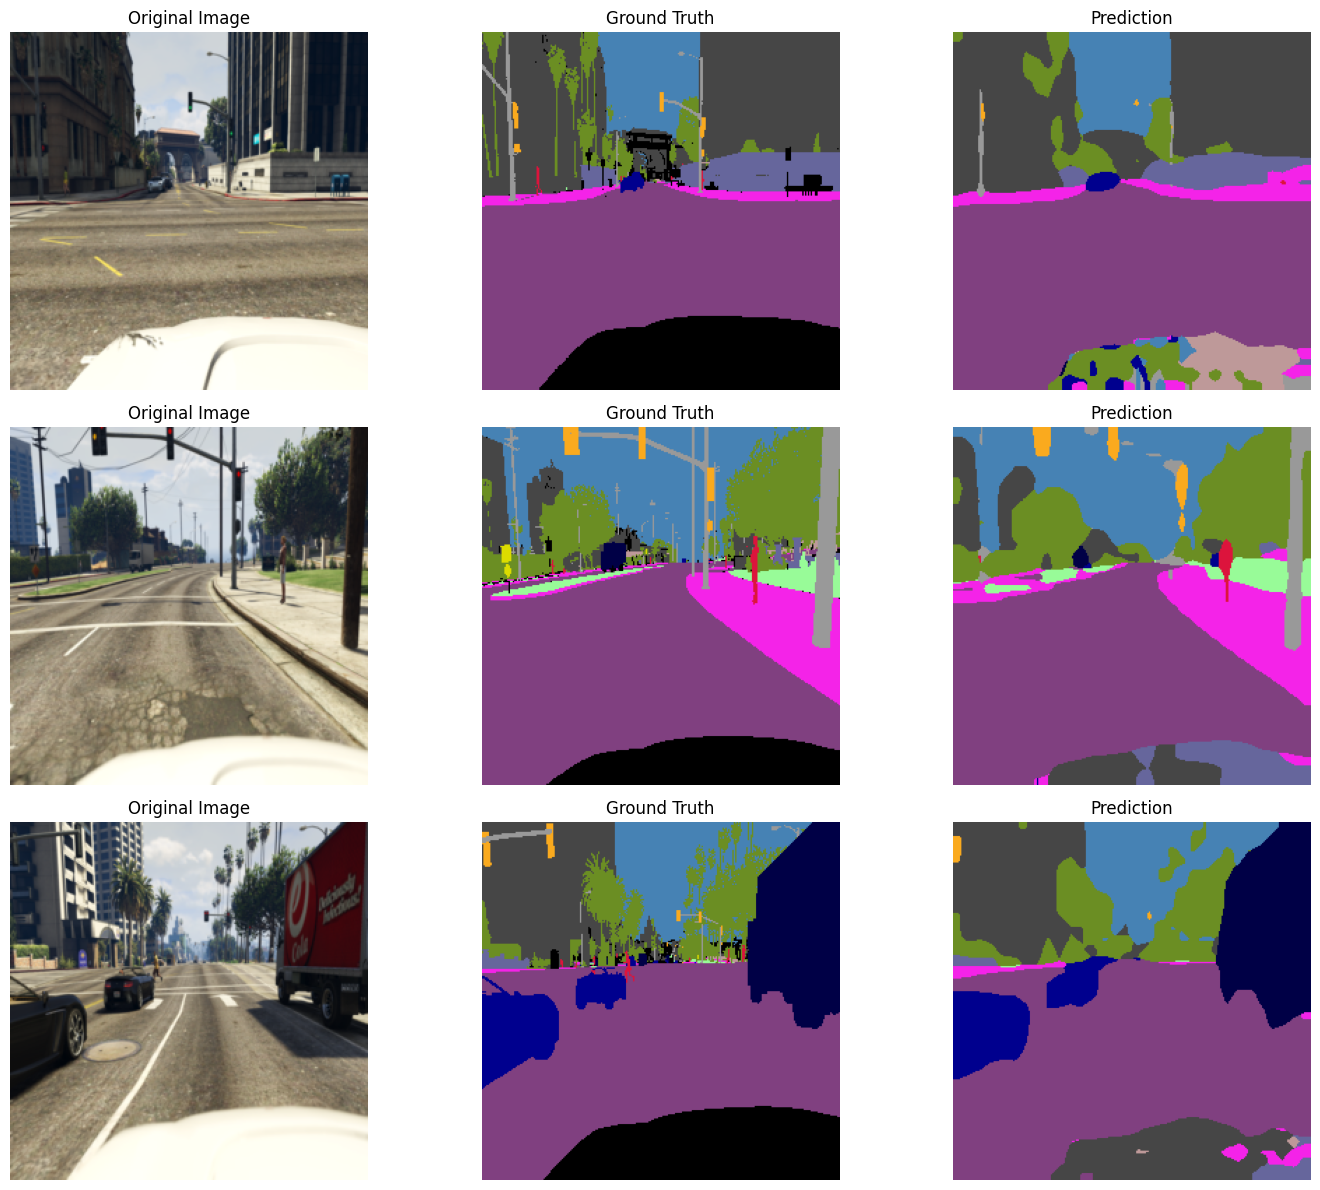


Training examples:


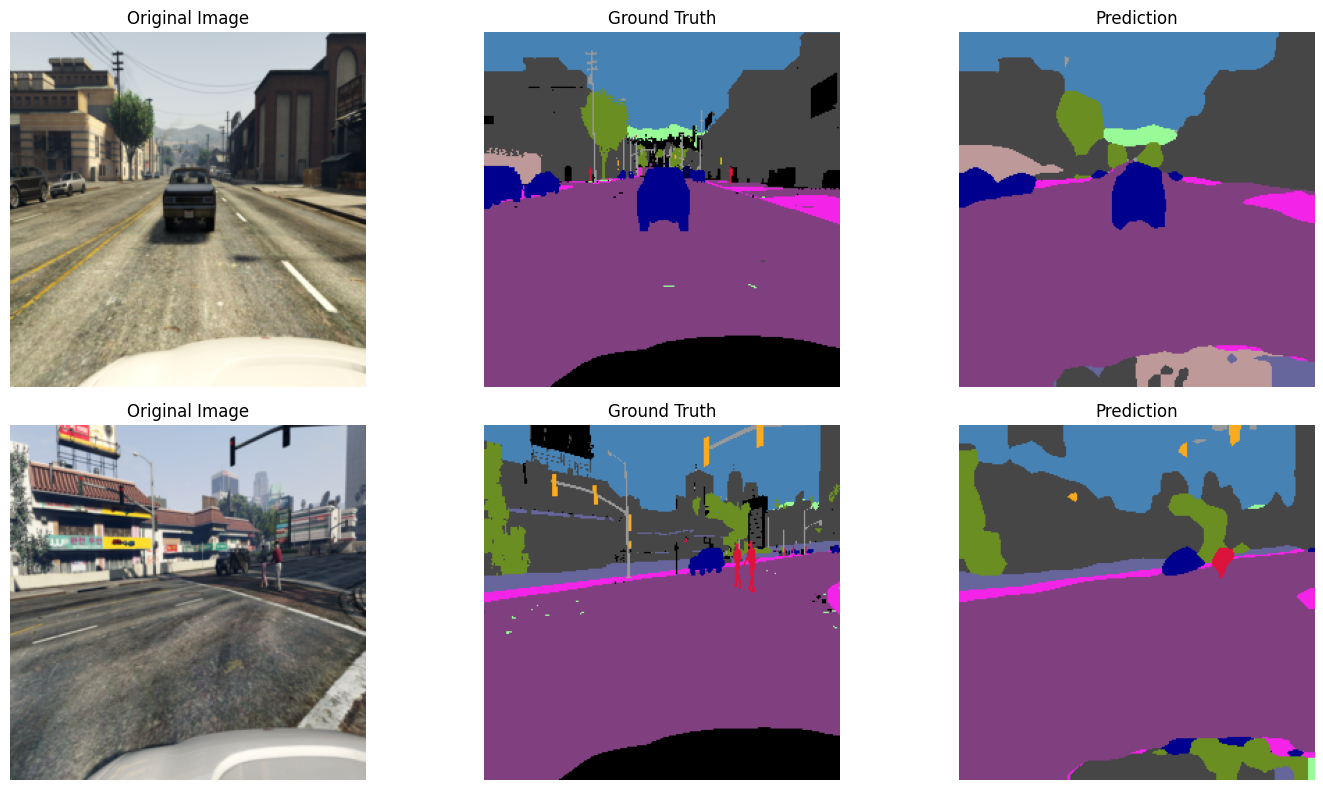

In [23]:
# Create color map for segmentation (using Cityscapes colors)
from cityscapesscripts.helpers import labels as cs_labels
def visualize_segmentation(model, dataloader, num_samples=4):
    """
    Visualize segmentation results from the model
    """
    model.eval()
    
    # Get a batch of data
    images, targets = next(iter(dataloader))
    images = images.to(DEVICE)
    targets = targets.to(DEVICE)
    
    with torch.no_grad():
        outputs = model(images)['out']
        predictions = torch.argmax(outputs, dim=1)
    
    # Move to CPU for visualization
    images = images.cpu()
    targets = targets.cpu()
    predictions = predictions.cpu()
    

    
    def apply_color_map(seg_map):
        """Apply color mapping to segmentation map"""
        colored_map = np.zeros((seg_map.shape[0], seg_map.shape[1], 3), dtype=np.uint8)
        
        # Get valid labels (excluding ignore classes)
        valid_labels = [label for label in cs_labels.labels if label.trainId != 255 and label.trainId != -1]
        
        for label in valid_labels:
            mask = seg_map == label.trainId
            colored_map[mask] = label.color
            
        return colored_map
    
    # Plot results
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 4))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(min(num_samples, len(images))):
        # Original image
        img = images[i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize for display
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        # Ground truth
        gt_colored = apply_color_map(targets[i].numpy())
        axes[i, 1].imshow(gt_colored)
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')
        
        # Prediction
        pred_colored = apply_color_map(predictions[i].numpy())
        axes[i, 2].imshow(pred_colored)
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize segmentation results on validation set
print("Visualizing segmentation results...")
visualize_segmentation(model, syn_val_dataloader, num_samples=3)

# Also show some training examples for comparison
print("\nTraining examples:")
visualize_segmentation(model, syn_train_dataloader, num_samples=2)